In [2]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Overview

Legends in matplotlib are relatively easy to make when plots are and it is not neccessary to customize, however, in scientific publications it is often necessary to make complicated figures, with special legends.
Here I'll share some of principles I follow, and methods I've discovered and/or extended to produce custom legends, customize legends, and make them look better for a scientific figures.

# 1) Basics 

# 1.1 A plot with a basic legend

In [3]:
df = sns.load_dataset('iris')

In [4]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


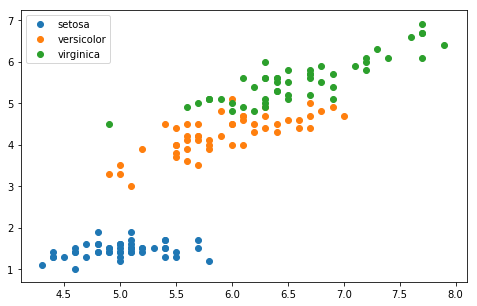

In [12]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
for sp, tdf in df.groupby('species'):
    # pass desired legend names to subgroups of data to label- or all groups will be labeled the same in legend
    h = ax.scatter(tdf['sepal_length'], tdf['petal_length'], label = sp)
    handles.append(h)
    
ax.legend()

# 1.2 How do Legends Work?

When you call `ax.legend` after plotting your data, legend elements are automatically determined from the plotted "Artists", see this great [tutorial](https://dev.to/skotaro/artist-in-matplotlib---something-i-wanted-to-know-before-spending-tremendous-hours-on-googling-how-tos--31oo) for a more detailed explanation of this. 

For convenience, I'll reiterate some basic information about Artists
Basically, when you plot data using `Axes` methods such as `ax.plot` or `ax.scatter`, Artists are added to the `Axes` canvas.

When you call `ax.legend` the legend is created with these artists/labels (handles) 

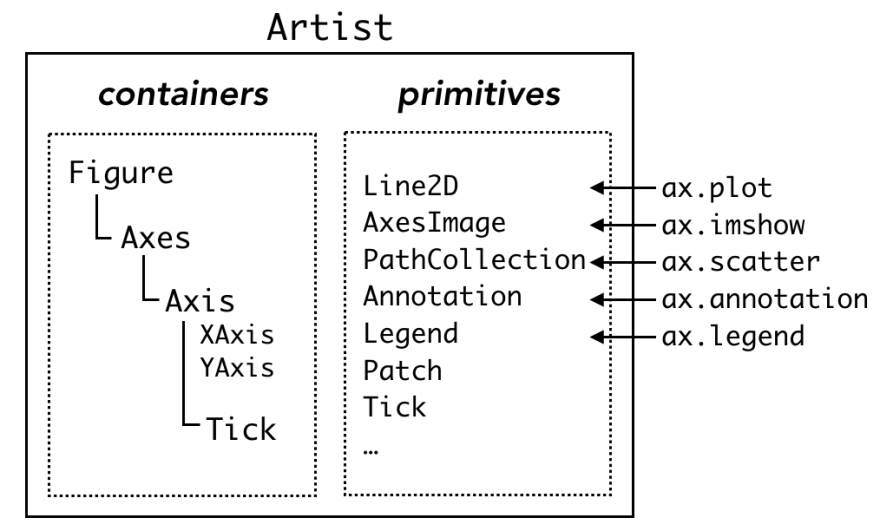



Note: Credit this diagram to ['@skotaro'](https://dev.to/skotaro) and the aforementioned tutorial


In [ ]:
/frazer01/home/djakubosky/repos/public/scientific-matplotlib/matplotlib_tutorials/media/Artists_scotaro.png

# 1.3 Excluding specific items from your legend, when you plot them
A common annoyance in using the automatic legend method, is that if you plot items that you don't wish to include on the legend, they will still appear, however, there are a few ways to remove them. Additionally, be aware that artists from some plotting methods will show up on the legend only if they have a label- this is true for `ax.axvline`

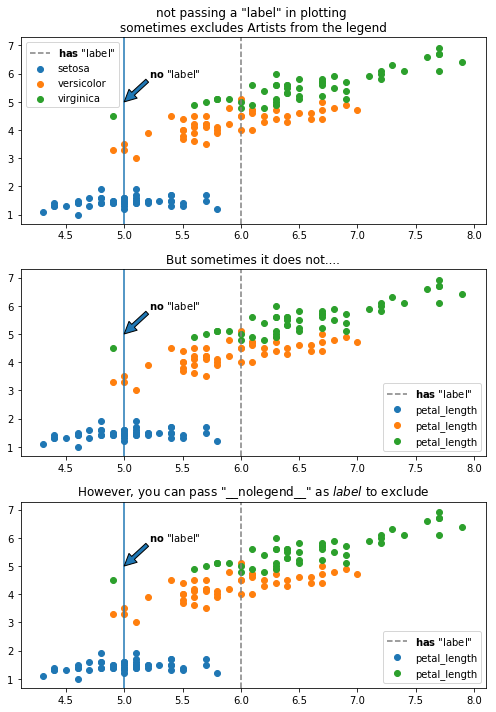

In [191]:
fig, axes = plt.subplots(3,1, figsize = (7,10))
ax = axes[0]
for sp, tdf in df.groupby('species'):
    # pass desired legend names to subgroups of data to label- or all groups will be labeled the same in legend
    h = ax.scatter(tdf['sepal_length'], tdf['petal_length'], label = sp)
    
# some items such as axvline actually won't be added to the legend if you don't label them 
ax.axvline(5)
ax.annotate(xy = (5,5), s = '$\mathbf{no}$ "label"', xytext = (25,25), textcoords = 'offset points', 
            arrowprops = {} )
ax.axvline(6, label = '$\mathbf{has}$ "label"', color = 'grey', linestyle = '--')

ax.legend()
ax.set_title('not passing a "label" in plotting \n sometimes excludes Artists from the legend ')

ax = axes[1]
for sp, tdf in df.groupby('species'):
    h = ax.scatter(tdf['sepal_length'], tdf['petal_length'])
    
# some items such as axvline actually won't be added to the legend if you don't label them 
ax.axvline(5)
ax.annotate(xy = (5,5), s = '$\mathbf{no}$ "label"', xytext = (25,25), textcoords = 'offset points', 
            arrowprops = {} )
ax.axvline(6, label = '$\mathbf{has}$ "label"', color = 'grey', linestyle = '--')

ax.legend(loc = 'lower right')
ax.set_title('But sometimes it does not....')


ax = axes[2]
for sp, tdf in df.groupby('species'):
    if sp == 'versicolor':
        h = ax.scatter(tdf['sepal_length'], tdf['petal_length'], label = '__nolegend__')
    else:
        h = ax.scatter(tdf['sepal_length'], tdf['petal_length'])
    
    
    
# some items such as axvline actually won't be added to the legend if you don't label them 
ax.axvline(5)
ax.annotate(xy = (5,5), s = '$\mathbf{no}$ "label"', xytext = (25,25), textcoords = 'offset points', 
            arrowprops = {} )
ax.axvline(6, label = '$\mathbf{has}$ "label"', color = 'grey', linestyle = '--')

ax.legend(loc = 'lower right')
ax.set_title('However, you can pass "__nolegend__" as $label$ to exclude')


plt.tight_layout()


# 2) Customizing Legends

## 2.1 Custom Defining Legend Using Artists
For greater control you can instead generate a list of handles (Artists with labels) and provide them directly to the `ax.legend` method. `Line2D` can take various markers, including latex symbols/texts, allowing you to use this artist to define many types of legend items. However, for more control, you'll need to define custom legend handler maps- some examples may also be found [here](https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend).  Below I've expanded upon an example given [here](https://matplotlib.org/3.1.0/gallery/text_labels_and_annotations/custom_legends.html) providing some added comments on things that aren't obvious from these tutorials.


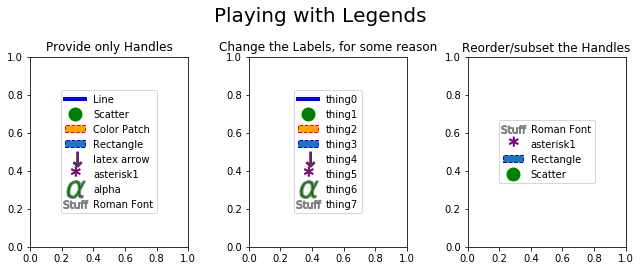

In [232]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# a list of "handles" can be made by plotting artists
legend_elements = [Line2D([0], [0], color='b', lw=4, label='Line'), #standard line- if you don't define a marker
                   Line2D([0], [0], marker='o', color='w', label='Scatter', # color line white or 
                          markerfacecolor='g', markersize=15),              # set lw = 0 for just a Circle
                   mpatches.Patch(facecolor='orange', edgecolor='r',  #Actually a Rectangle patch, with fc, ec...
                         label='Color Patch', linestyle = '--'), 
                   mpatches.Rectangle((0, 0), 0, 0,
                                       label = 'Rectangle', linestyle = '--', linewidth = 1, 
                                       edgecolor = 'b'), #See, does the same thing as Patch
                   Line2D([0], [0], marker=r'$\downarrow$', color='purple', label='latex arrow',
                          markerfacecolor='g', markersize=15, lw = 0), ### latex markers can also be used
                   Line2D([], [], marker=r'$ * $', color='purple', label='asterisk1',
                          markerfacecolor='g', markersize=15, lw = 0),
                   # you can also use general texts, but they will default to the style of latex 
                   Line2D([], [], marker=r'$\alpha$', color='grey', label='alpha',
                          markerfacecolor='g', markersize=20, lw = 0),
                   Line2D([], [], marker=r"$\mathrm{Stuff}$", color='grey', label='Roman Font',
                          markerfacecolor='g', markersize=25, lw = 0)]  # or you can also use mathtext
                    
fig, axes = plt.subplots(1,3, figsize = (10,4))
axf = axes.flatten()
ax = axf[0]
ax.set_title('Provide only Handles')
# provide a list of handles- by default it will have the provided labels
ax.legend(handles=legend_elements, loc='center');


ax = axf[1]
ax.set_title('Change the Labels, for some reason')
# provide a list of handles- by default it will have the provided labels
labels = ['thing{}'.format(i) for i,l in enumerate(legend_elements)]
ax.legend(handles=legend_elements, labels = labels, loc='center');



ax = axf[2]
ax.set_title('Reorder/subset the Handles')
# you can always play around with this list of handles
# provide a list of handles- by default it will have the provided labels
leg = ax.legend(handles=legend_elements[::-1][::2], loc='center');


fig.suptitle('Playing with Legends', fontsize = 20)
plt.tight_layout(rect = [0.05, 0.05, 0.95, 0.9])

# Grabbing/Reusing Handles Cont.

Regardless of how they are drawn, you can get a list of handles on the plot, use them elsewhere/modify
and use them on other axes if you wish, or in both places, this can also allow you to exclude things from the legend.   
-The `ax.get_legend_handles_labels` method is helpful for this.  
-This is also useful if you are using Seaborn, you'll find that sometimes it creates legends with extra items to hide (eg `sns.scatterplot`).

However, you can only have one "legend" tied to an axes at a time, we will revisit this issue later.

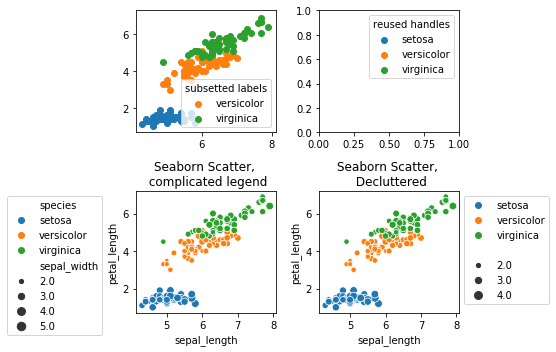

In [227]:
fig, axes = plt.subplots(2,2, figsize = (8,5))
axf = axes.flatten()
ax = axf[0]
for sp, tdf in df.groupby('species'):
    h = ax.scatter(tdf['sepal_length'], tdf['petal_length'], label = sp)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = handles[1:], title = 'subsetted labels');


ax = axf[1]
ax.legend(handles = handles, title = 'reused handles');


ax = axf[2]

ax.set_title('Seaborn Scatter, \n complicated legend')
sns.scatterplot(x = 'sepal_length', y = 'petal_length', data = df, hue = 'species', ax = ax,
               size = 'sepal_width' )

# its long so I'll move it outside
leg = ax.legend(bbox_to_anchor = (-0.2, 1), loc = 'upper right')

handles, labels  = ax.get_legend_handles_labels()

# seaborn actually puts titles in legends as items of the legend in some cases
# things would look cleaner with white space 
t = set(['species','sepal_width'])
new_labels = [i if i not in t else '' for i in labels]


ax = axf[3]
sns.scatterplot(x = 'sepal_length', y = 'petal_length', data = df, hue = 'species', ax = ax,
               size = 'sepal_width' )
# lets clean it up and place it somewhere better
ax.legend(handles = handles[1:-1], labels = new_labels[1:-1], bbox_to_anchor = (1,1), loc = 'upper left')

ax.set_title('Seaborn Scatter, \n Decluttered')
plt.tight_layout()


# 2.3 Custom Legend Handlers
It is sometimes neccessary to create a custom legend handler class, if you wish to use a non-standard legend marker. 

Legend Handlers return an Artist.

When do you need to worry about this?  

   1) when you need to ensure texts are the same size      
   2) you want special shapes as the legend markers, that can't be passed via Line2D as scatter markers or as Rectangles
    

Others have described pretty well placing patches into the legend, for example this [stackoverflow](https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend)

Below I'll illustrate the issue as it pertains to special texts 


# Use-Case: Line2D with MathTexts/Latex Creates Texts that are Different Sizes
Lets say we want to display asterisks in a legend, with several asterisks indicating a lower p value, this doesn't look too good using "Proxy artists" - see matplotlib [legend tutorial](https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists)- But can be done like so - this solution is inspired by these two strong stackoverflow answers [1](https://stackoverflow.com/questions/43585333/seaborn-countplot-set-legend-for-x-values/43591678#43591678), [2](https://stackoverflow.com/questions/47372459/use-text-but-not-marker-in-matplotlib-legend), with a bit of detail added

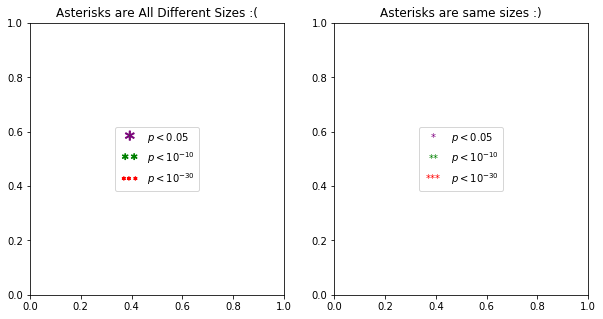

In [321]:

from matplotlib.legend_handler import HandlerBase
import copy




labels = ['$p < 0.05$', '$p < 10^{-10}$', '$p < 10^{-30}$']
markers = [r'$   *$', r'$  **$', r'$ ***$']
colors = ['purple', 'green', 'red']

legend_elements = []

for i in range(len(markers)):
    l = Line2D([], [], marker= markers[i], color=colors[i], label=labels[i],
                          markerfacecolor='g', markersize=15, lw = 0)
    legend_elements.append(l)

fig, axes = plt.subplots(1,2, figsize = (10,5))
ax = axes[0]
ax.set_title('Asterisks are All Different Sizes :(')
# provide a list of handles- by default it will have the provided labels
ax.legend(handles=legend_elements, loc='center');


#####LegendHandler just for Text can be made in this way
class TextHandler(HandlerBase):
        def create_artists(self, legend, orig_handle,xdescent, ydescent,
                            width, height, fontsize,trans):
            h = copy.copy(orig_handle)
            # center the Text within the region between label and Legend Bbox
            h.set_position((width/2.,height/2.))
            h.set_transform(trans)
            h.set_ha("center");
            h.set_va("center");
            return [h]

texts = []
leg_texts = ['*', '**', '***']
labels = ['$p < 0.05$', '$p < 10^{-10}$', '$p < 10^{-30}$']
fs = 10
for i, lt in enumerate(leg_texts):
    t = plt.Text(x=0, y = 0, text = lt, color = colors[i],
             size = 10, label = labels[i])
    texts.append(t)
    
handlermap = {type(texts[0]) : TextHandler()}

ax  = axes[1]

ax.set_title('Asterisks are same sizes :)')
ax.legend(handles=texts, loc='center', handler_map=handlermap);







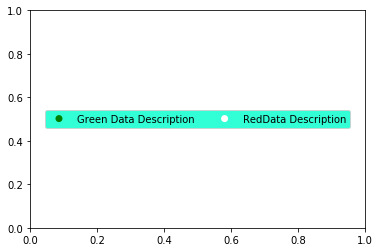

In [249]:
from matplotlib.legend_handler import HandlerPatch
colors = ["g", "w"]
texts = ["Green Data Description", "RedData Description"]
class HandlerEllipse(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.Ellipse(xy=center, width=width + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]


    
class HandlerEllipse2(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        center = 0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent
        p = mpatches.(xy=center, width=height + xdescent,
                             height=height + ydescent)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]

# c = [ mpatches.Circle((0.5, 0.5), 1, facecolor=colors[i], linewidth=3) for i in range(len(texts))]
# plt.legend(c,texts,bbox_to_anchor=(0.5, 0.5), loc='center', ncol=2, handler_map={mpatches.Circle: HandlerEllipse()}).get_frame().set_facecolor('#00FFCC')



c = [ mpatches.Circle((0.5, 0.5), radius = 0.25, facecolor=colors[i], edgecolor="none" ) for i in range(len(texts))]
plt.legend(c,texts,bbox_to_anchor=(0.5, 0.5), loc='center', ncol=2, handler_map={mpatches.Circle: HandlerEllipse2()}).get_frame().set_facecolor('#00FFCC')